<a href="https://colab.research.google.com/github/ihsan02tempest/Batik-CNN-MobileNet-transfer-learning/blob/master/TA_Batik_TFLite_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TRAINING DATASET MOTIF BATIK MENGGUNAKAN PENDEKATAN MOBILENET DAN FRAMEWORK TENSORFLOWLITE

Sample yang dibutuhkan =
1. Motif Batik Corak Insang
2. Motif Batik Dayak
3. Motif Batik Megamendung
4. Motif Batik Ikat Celup

Source = https://www.kaggle.com/datasets/ihsan10/motif-batik-ta

In [ ]:
#@title MOUNT DATA DARI GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title ALOKASI AKSES KE FILE DATASET KAGGLE
! chmod 600 /content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/kaggle.json

In [ ]:
#@title AKSES PENYIMPANAN GOOGLE DRIVE UNTUK MENGIMPORT DATASET
! KAGGLE_CONFIG_DIR=/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/ kaggle datasets download -d ihsan10/motif-batik-ta

100% 115M/115M [00:07<00:00, 24.5MB/s]
100% 115M/115M [00:07<00:00, 16.4MB/s]


In [ ]:
#@title IMPORT DAN EKSTRAK ZIP YANG DIBUTUHKAN
import zipfile
zip_file = zipfile.ZipFile('/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik.zip')
zip_file.extractall('/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/')

In [ ]:
#@title IMPORT LIBRARY YANG DIBUTUHKAN
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, InputLayer, ZeroPadding2D, BatchNormalization, DepthwiseConv2D
from keras.preprocessing import image
from keras.optimizers import adam_v2
from tensorflow import keras
from keras.applications.mobilenet import MobileNet
from tensorflow import lite
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_cpu_global_jit"

In [ ]:
#@title PENENTUAN PARAMETER PELATIHAN DATA
train_data_dir = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik/TRAIN'
validation_data_dir = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik/VALIDATION'
test_data_dir = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik/TEST'

label_class = ["Batik Corak Insang", "Batik Dayak", "Batik Ikat Celup", "Batik Megamendung"]
img_width, img_height = 128, 128
image_size = 128
num_train = 240
num_test = 80
num_val = 80

In [ ]:
#@title PRE-PROCESSING
train_datagen = ImageDataGenerator( rescale=1/255,
                                   horizontal_flip=True, #horizontal flip 
                                   vertical_flip=True, #vertical flip 
                                   fill_mode='nearest') #mengisi piksel kosong terdekat

validation_datagen = ImageDataGenerator( rescale = 1/255 )

test_datagen = ImageDataGenerator( rescale = 1/255 )

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    classes=label_class,
                                                    batch_size=32,
                                                    class_mode='categorical', #multiclass
                                                    target_size = (128, 128), #resize 128x128px
                                                    shuffle=True) #data diacak

validation_generator = test_datagen.flow_from_directory(validation_data_dir, 
                                                    batch_size=32,
                                                    classes=label_class,
                                                    class_mode='categorical',
                                                    target_size = (128, 128), #resize 128x128px
                                                    shuffle=False)

test_generator = test_datagen.flow_from_directory(test_data_dir, 
                                                    batch_size=32,
                                                    classes=label_class,
                                                    class_mode='categorical',
                                                    target_size = (128, 128), #resize 128x128px
                                                    shuffle=False)

Found 440 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [ ]:
#@title MENGGUNAKAN PERFORMA MODEL MOBILENET PADA TRANSFER LEARNING 
base_model = MobileNet(weights='imagenet',
                         include_top=False,
                         input_shape=(128, 128, 3))
base_model.trainable = False
base_model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32) 

In [ ]:
#@title MENGGUNAKAN PRETRAINED MODEL TRANSFER LEARNING DAN KLASIFIKASI LAYER BARU
from keras import layers
inputs = keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
#@title COMPILE MODEL MENGGUNAKAN OPTIMASI ADAM
opt = adam_v2.Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, amsgrad=True, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#@title CHECKPOINT PENYIMPANAN MODEL DENGAN BOBOT TERTENTU
#import ModelCheckpoint
from keras.callbacks import ModelCheckpoint

#menentukan path folder menyimpan model
filepath = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/my-saved-model/model6/model-batik.h5'

#Menyimpan Model dengan kriteria tertentu
checkpoint = ModelCheckpoint(filepath,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
#@title TRANING MODEL
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    steps_per_epoch=10,
                    epochs=50,
                    validation_steps=10,
                    callbacks=[checkpoint],
                    verbose=1,
                    use_multiprocessing=True,
                    workers=4)

Epoch 1/50
10/10 [==============================] - 28s 2s/step - loss: 0.9715 - accuracy: 0.6531 - val_loss: 0.3441 - val_accuracy: 0.8640
Epoch 2/50
10/10 [==============================] - 23s 2s/step - loss: 0.2385 - accuracy: 0.9156 - val_loss: 0.1274 - val_accuracy: 0.9375
Epoch 3/50
10/10 [==============================] - 25s 2s/step - loss: 0.1302 - accuracy: 0.9438 - val_loss: 0.0826 - val_accuracy: 0.9779
Epoch 4/50
10/10 [==============================] - 23s 2s/step - loss: 0.0747 - accuracy: 0.9808 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 25s 2s/step - loss: 0.0624 - accuracy: 0.9875 - val_loss: 0.0499 - val_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 25s 2s/step - loss: 0.0409 - accuracy: 0.9968 - val_loss: 0.0419 - val_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 24s 2s/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 1.0000
Epoch 8/50
10/10 [==

In [ ]:
#@title SUMMARY MODEL
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 4, 4, 128)         131200    
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0         
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0     

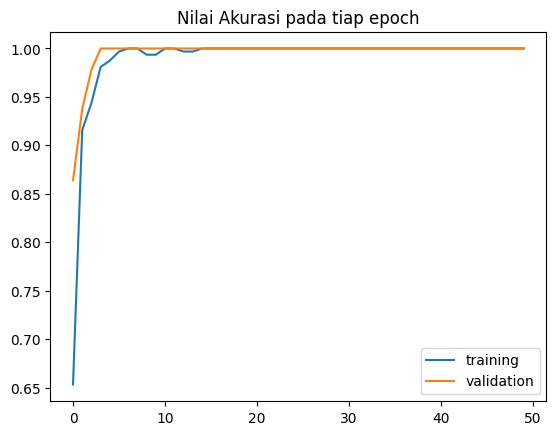

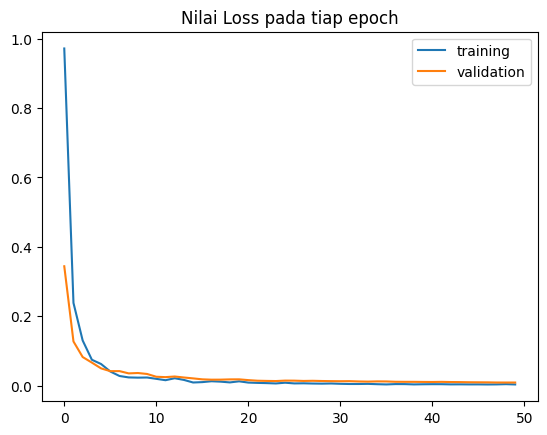

In [ ]:
#@title GRAFIK NILAI TRAINING DAN VALIDASI TRAINING
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Nilai Akurasi pada tiap epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Nilai Loss pada tiap epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [ ]:
#@title EVALUASI MODEL TRAINING
model.load_weights(filepath)
train_loss, train_accuracy = model.evaluate(train_generator, verbose=2)
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=2)

14/14 - 15s - loss: 0.0032 - accuracy: 1.0000 - 15s/epoch - 1s/step
3/3 - 2s - loss: 0.0087 - accuracy: 1.0000 - 2s/epoch - 664ms/step


In [ ]:
model.save('/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/my-saved-model/model6/model-batik.h5')
loaded_model=tf.keras.models.load_model('/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/my-saved-model/model6/model-batik.h5')

In [ ]:
loaded_model_json = loaded_model.to_json()
with open('loaded_model.json', 'w') as json_file:
    json_file.write(loaded_model_json)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/my-saved-model/model6/converted_model.tflite", "wb").write(tflite_model)

13332672

In [ ]:
#@title PENGUJIAN METRIK
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = loaded_model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(test_generator.classes, predicted_classes, target_names=class_labels)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_classes))
print('Classification Report')
print(report)

4/4 [==============================] - 10s 2s/step
Confusion Matrix
[[30  0  0  0]
 [ 0 30  0  0]
 [ 0  0 30  0]
 [ 0  0  0 30]]
Classification Report
                    precision    recall  f1-score   support

Batik Corak Insang       1.00      1.00      1.00        30
       Batik Dayak       1.00      1.00      1.00        30
  Batik Ikat Celup       1.00      1.00      1.00        30
 Batik Megamendung       1.00      1.00      1.00        30

          accuracy                           1.00       120
         macro avg       1.00      1.00      1.00       120
      weighted avg       1.00      1.00      1.00       120



1/1 [==============================] - 0s 52ms/step
Predicted class: Batik Corak Insang


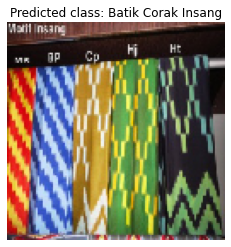

In [ ]:
#@title TEST PERFORMA MODEL DENGAN GAMBAR TEST

from PIL import Image

img_path = '/content/drive/MyDrive/Colab-Notebooks/KLASIFIKASI-BATIK/gambar motif batik/TEST/Batik Corak Insang/110.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array/255, axis=0)

# make prediction on the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

# print the predicted class label
print('Predicted class:', class_labels[predicted_class])

# plot the image and the predicted label
plt.imshow(img)
plt.axis('off')
plt.title('Predicted class: ' + class_labels[predicted_class])
plt.show()

In [ ]:
#@title SUMMARY PENGUJIAN METRIK
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# hitung akurasi
accuracy = accuracy_score(test_generator.classes, predicted_classes)
# hitung presisi
precision = precision_score(test_generator.classes, predicted_classes, average='weighted')
# hitung recall
recall = recall_score(test_generator.classes, predicted_classes, average='weighted')
# hitung f1-score
f1 = f1_score(test_generator.classes, predicted_classes, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


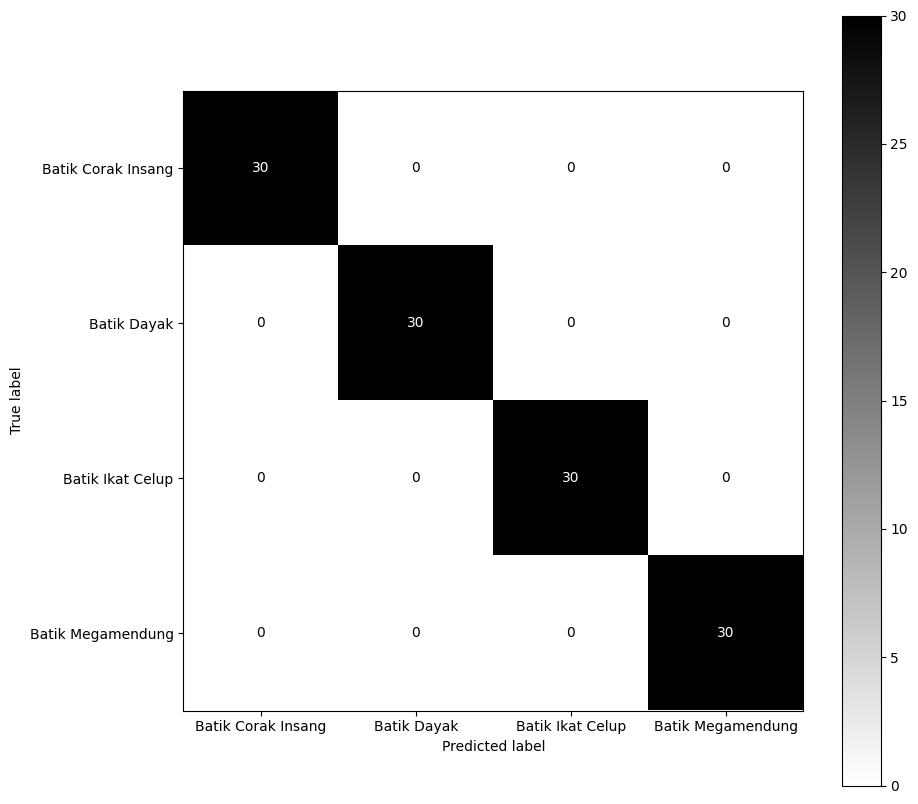

In [ ]:
#@title VISUALISASI DARI HASIL PENGUJIAN METRIK
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(test_generator.classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_class)
disp.plot(cmap=plt.cm.binary, ax=ax)
plt.show()